In [1]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
from sklearn.preprocessing import StandardScaler
from models.single_layer_perceptron import SingleLayerPerceptron

In [2]:
ticker = 'B3SA3.SA'
prices = yf.Ticker(ticker).history('max')
prices = prices.drop(['Volume', 'Dividends', 'Stock Splits'], 1)
prices.head()

<ipython-input-2-fde6207d9880>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  prices = prices.drop(['Volume', 'Dividends', 'Stock Splits'], 1)


,Open,High,Low,Close
Date,,,,
2007-10-26,19.503840,21.533459,17.681450,21.326231
2007-10-29,21.088523,21.088523,19.503838,19.503838
2007-10-30,19.503840,19.656214,18.900440,18.985769
2007-10-31,19.211283,20.113336,19.192998,19.808588
2007-11-01,19.869529,20.101138,19.272226,20.076757


In [3]:
y = prices.Close.shift(-5)
prices['y'] = y

In [4]:
prices.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [5]:
prices['SMA_5'] = prices.ta.sma(5)
prices['SMA_30'] = prices.ta.sma(30)
prices['SMA_60'] = prices.ta.sma(60)
prices['RSI_5'] = prices.ta.rsi(5)
prices['RSI_30'] = prices.ta.rsi(30)
prices['RSI_60'] = prices.ta.rsi(60)
prices = pd.concat([prices, ta.donchian(prices["High"], prices["Low"], lower_length=10, upper_length=15)], 1)
prices =  prices.dropna()

columns = list(prices.columns)
columns.remove('y')
prices_scaled = pd.DataFrame(StandardScaler().fit_transform(prices[columns]), columns=columns, index = prices.index)
prices_scaled['y'] = prices.y

<ipython-input-5-5d89176a11cc>:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  prices = pd.concat([prices, ta.donchian(prices["High"], prices["Low"], lower_length=10, upper_length=15)], 1)


In [6]:
trading_threshold = '2021-10-31'
prices.index = pd.to_datetime(prices.index)
train_prices = prices[(prices.index <= trading_threshold) & (prices.index.year >= 2016)]
test_prices = prices[prices.index > trading_threshold]

In [7]:
train_X = train_prices.drop('y', 1)
train_y = train_prices.y
test_X = test_prices.drop('y', 1)
test_y = test_prices.y

<ipython-input-7-9edf73517eb2>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  train_X = train_prices.drop('y', 1)
<ipython-input-7-9edf73517eb2>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  test_X = test_prices.drop('y', 1)


In [13]:
slp = SingleLayerPerceptron(train_X.shape[1])
X = train_X.to_numpy()
y = train_y.to_numpy()
slp.train(X, y)
slp.saved_errors[-5:]

[1.5962980158422726e-06,
 1.4157379818715248e-06,
 1.255601520569609e-06,
 1.1135784488762412e-06,
 9.876199019884724e-07]

In [16]:
size = train_X.shape[1]
slp = SingleLayerPerceptron(size)
slp.learning_rate = 1e-4

In [17]:
slp.train(train_X.to_numpy(), train_y.to_numpy())
slp.saved_errors[-5:]

[0.0001003440875695329,
 0.0001002303912130379,
 0.00010011682373595873,
 0.0001000033849921221,
 9.989007483539936e-05]

In [19]:
from sklearn.metrics import mean_absolute_error

pred = slp.predict(test_X)
mean_absolute_error(test_y, pred)

2.1487420025597985

<AxesSubplot:xlabel='Date'>

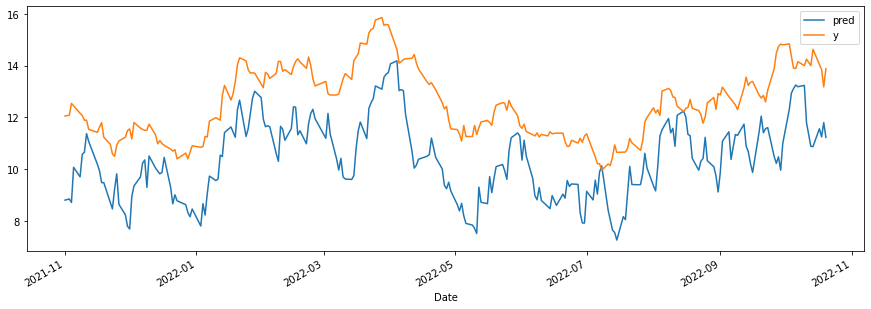

In [22]:
df = pd.DataFrame()
df['pred'] = pred
df['y'] = test_y
df.plot(figsize=(15, 5))